In [1]:
import kagglehub
bmadushanirodrigo_fracture_multi_region_x_ray_data_path = kagglehub.dataset_download('bmadushanirodrigo/fracture-multi-region-x-ray-data')

print('Data source import complete.')

Using Colab cache for faster access to the 'fracture-multi-region-x-ray-data' dataset.
Data source import complete.


In [2]:
# Cell 1: Imports and Environment Setup
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from PIL import Image, ImageFile

# Ensure reproducibility and handle potential image errors
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.random.set_seed(42)
np.random.seed(42)

In [8]:
# Cell 2: Data Loading and Cleaning
# This assumes the dataset is available at the standard Kaggle path.
base_dir = os.path.join(bmadushanirodrigo_fracture_multi_region_x_ray_data_path, "Bone_Fracture_Binary_Classification", "Bone_Fracture_Binary_Classification")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except Exception:
        return False

def clean_folder(root):
    if not os.path.exists(root):
        print(f"Directory not found: {root}")
        return
    removed_count = 0
    for class_dir in os.listdir(root):
        class_path = os.path.join(root, class_dir)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if os.path.isfile(img_path) and not is_valid_image(img_path):
                    try:
                        os.remove(img_path)
                        removed_count += 1
                    except Exception as e:
                        print(f"Error removing file {img_path}: {e}")
    if removed_count > 0:
        print(f"Removed {removed_count} invalid images from {root}.")

clean_folder(train_dir)
clean_folder(val_dir)
clean_folder(test_dir)
print("Image cleanup complete.")

Image cleanup complete.


In [9]:
import os

# List contents of the base directory to check its structure
base_dir = os.path.join(bmadushanirodrigo_fracture_multi_region_x_ray_data_path, "Bone_Fracture_Binary_Classification")

print(f"Contents of {base_dir}:")
if os.path.exists(base_dir):
    for item in os.listdir(base_dir):
        print(item)
else:
    print(f"Base directory not found: {base_dir}")

Contents of /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification:
Bone_Fracture_Binary_Classification


In [10]:
# Cell 3: Data Generators with Strong Augmentation
IMG_SIZE = 224  # DenseNet was pretrained on 224x224 images
BATCH_SIZE = 32

# Stronger augmentation tailored for medical images
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)

Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Classes: ['fractured', 'not fractured']


In [11]:
# Cell 4: Build the Model with DenseNet121

def build_model(num_classes):
    # Load DenseNet121 with ImageNet weights, freezing it initially
    base_model = applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )
    base_model.trainable = False

    # Build a robust head for the model
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x) # Increased dropout for regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_model(num_classes=len(class_names))

# Compile for the first stage (training the head)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,304,514 (27.86 MB)

 Trainable params: 264,962 (1.01 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [12]:
# Cell 5: Stage 1 Training (Train the Head)
# This warms up the new layers on top of the frozen base model.

print("--- Starting Stage 1: Training the model head ---")
history_head = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
    ]
)

print("\n--- Stage 1 complete. Best validation accuracy: {:.4f} ---".format(max(history_head.history['val_accuracy'])))

--- Starting Stage 1: Training the model head ---
Epoch 1/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8220 - loss: 0.4022

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


289/289 ━━━━━━━━━━━━━━━━━━━━ 184s 559ms/step - accuracy: 0.8222 - loss: 0.4016 - val_accuracy: 0.9505 - val_loss: 0.1439
Epoch 2/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 438ms/step - accuracy: 0.9615 - loss: 0.1052 - val_accuracy: 0.9590 - val_loss: 0.1065
Epoch 3/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 126s 437ms/step - accuracy: 0.9771 - loss: 0.0624 - val_accuracy: 0.9747 - val_loss: 0.0728
Epoch 4/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 130s 451ms/step - accuracy: 0.9869 - loss: 0.0418 - val_accuracy: 0.9674 - val_loss: 0.0893
Epoch 5/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 438ms/step - accuracy: 0.9888 - loss: 0.0338 - val_accuracy: 0.9686 - val_loss: 0.0729
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.

--- Stage 1 complete. Best validation accuracy: 0.9747 ---


In [13]:
# Cell 6: Stage 2 Training (Fine-Tuning)
# Unfreeze the last dense block of DenseNet121 and train with a low learning rate.

# Unfreeze the last dense block and the final normalization layer
base_model = model.layers[1]
base_model.trainable = True

# Find the start of the last dense block to unfreeze
# For DenseNet121, 'conv5_block1_0_bn' is a good starting point
unfreeze_from = 'conv5_block1_0_bn'
unfreeze = False
for layer in base_model.layers:
    if layer.name == unfreeze_from:
        unfreeze = True
    if unfreeze:
        layer.trainable = True
    else:
        layer.trainable = False

print(f"\nFine-tuning from layer: {unfreeze_from}")
print(f"Number of trainable weights: {len(model.trainable_weights)}")

# Re-compile with a much lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5), # A good LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for fine-tuning
fine_tune_callbacks = [
    ModelCheckpoint('best_densenet_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1) # More patience for fine-tuning
]

print("\n--- Starting Stage 2: Fine-tuning the model ---")
history_fine_tune = model.fit(
    train_generator,
    epochs=20, # Allow up to 20 epochs; EarlyStopping will handle the rest
    validation_data=val_generator,
    callbacks=fine_tune_callbacks
)


Fine-tuning from layer: conv5_block1_0_bn
Number of trainable weights: 104

--- Starting Stage 2: Fine-tuning the model ---
Epoch 1/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 249s 679ms/step - accuracy: 0.9741 - loss: 0.0737 - val_accuracy: 0.9879 - val_loss: 0.0457 - learning_rate: 5.0000e-05
Epoch 2/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 126s 437ms/step - accuracy: 0.9917 - loss: 0.0231 - val_accuracy: 0.9879 - val_loss: 0.0384 - learning_rate: 5.0000e-05
Epoch 3/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 133s 461ms/step - accuracy: 0.9951 - loss: 0.0151 - val_accuracy: 0.9928 - val_loss: 0.0220 - learning_rate: 5.0000e-05
Epoch 4/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 133s 459ms/step - accuracy: 0.9969 - loss: 0.0102 - val_accuracy: 0.9940 - val_loss: 0.0181 - learning_rate: 5.0000e-05
Epoch 5/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 438ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.9928 - val_loss: 0.0216 - learning_rate: 5.0000e-05
Epoch 6/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 142s 439ms/step - accuracy: 0.9959 


--- Evaluating on Test Set with the Best Model ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9765 - loss: 0.0600

Final Test Accuracy: 0.9921
Final Test Loss: 0.0226
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      0.98      0.99       238
not fractured       0.99      1.00      0.99       268

     accuracy                           0.99       506
    macro avg       0.99      0.99      0.99       506
 weighted avg       0.99      0.99      0.99       506



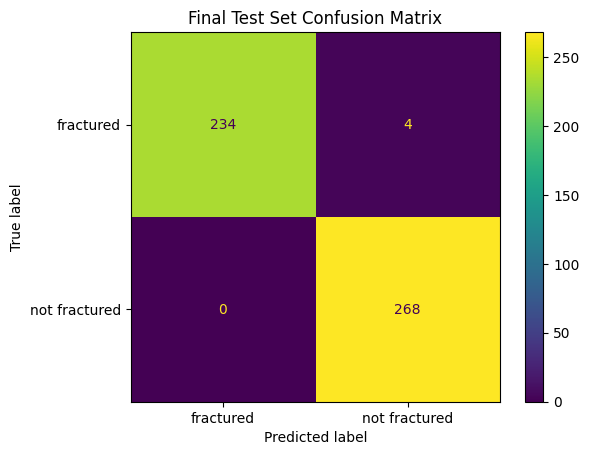

In [14]:
# Cell 7: Final Evaluation
# Load the best performing model saved during fine-tuning
model = keras.models.load_model('best_densenet_model.keras')

print("\n--- Evaluating on Test Set with the Best Model ---")
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

# Generate detailed classification report and confusion matrix
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="viridis", values_format='d')
plt.title("Final Test Set Confusion Matrix")
plt.grid(False)
plt.show()

Model 'best_densenet_model.keras' loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Prediction: not fractured
Confidence: 100.00%


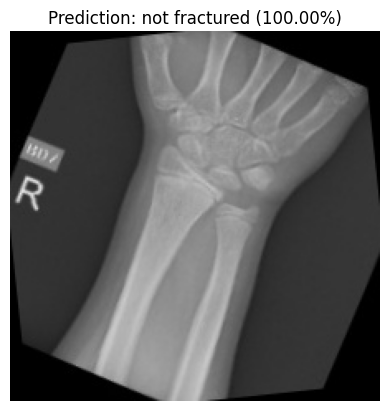

In [15]:
# Cell 8: Code to Test an External Image

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# --- Configuration ---
IMG_SIZE = 224
MODEL_PATH = 'best_densenet_model.keras'
CLASS_NAMES = ['fractured', 'not fractured'] # Make sure this order is correct

# --- Load the trained model ---
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f"Model '{MODEL_PATH}' loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    # Create a dummy model if loading fails, to avoid further errors
    model = None

# --- Preprocessing function for a single image ---
def preprocess_image(img_path):
    """Loads and preprocesses an image for model prediction."""
    try:
        # Load the image, resizing it to the required input size
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))

        # Convert the image to a numpy array
        img_array = image.img_to_array(img)

        # Rescale the pixel values to [0, 1]
        img_array /= 255.0

        # Expand dimensions to create a batch of 1
        img_batch = np.expand_dims(img_array, axis=0)

        return img, img_batch
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None, None

# --- Prediction function ---
def predict_external_image(model, img_path):
    """Makes a prediction on an external image and displays the result."""
    if model is None:
        print("Model is not available. Cannot make a prediction.")
        return

    original_img, processed_img = preprocess_image(img_path)

    if processed_img is None:
        return

    # Make prediction
    prediction_probs = model.predict(processed_img)[0]

    # Get the predicted class index and confidence score
    predicted_class_index = np.argmax(prediction_probs)
    confidence = np.max(prediction_probs) * 100
    predicted_class_name = CLASS_NAMES[predicted_class_index]

    # Display the result
    print(f"Prediction: {predicted_class_name}")
    print(f"Confidence: {confidence:.2f}%")

    # Show the image with the prediction as the title
    plt.imshow(original_img)
    plt.title(f"Prediction: {predicted_class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

image_path_to_test = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/1-rotated1-rotated2-rotated3-rotated1.jpg'

if os.path.exists(image_path_to_test):
    predict_external_image(model, image_path_to_test)
else:
    print(f"Error: The file '{image_path_to_test}' was not found.")
    print("Please update the 'image_path_to_test' variable with a valid file path.")
